In [1]:
from sqlalchemy import create_engine, select
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
engine = create_engine('postgresql://develop:}c%4Z>n~M<3p:Em\@localhost:5432/football')

In [3]:
def get_dataframe(sql):
    with Session(engine) as session:
        return pd.DataFrame(session.execute(sql))
    
def plot_category(category,ax):
    sql = f'\
Select \
event_qualifiers.name AS category,\
	count(*) FILTER (WHERE is_goal AND NOT is_own_goal) AS "Goals",\
	count(*) FILTER (WHERE is_goal and is_own_goal) AS "Own Goals" \
FROM core.events \
JOIN core.event_qualifiers ON event_qualifiers.id = events.{category} \
JOIN core.event_types ON event_types.id = events.type \
WHERE event_types.name = \'goal\' \
GROUP BY category'
    frame = get_dataframe(sql)
    frame.set_index(frame.columns[0], inplace=True)
    frame['sum'] = frame.sum(axis=1)
    frame.sort_values('sum', inplace = True, ascending = False)
    del frame['sum']
    plot = frame.plot.barh(ax=ax,stacked=True,title = category, xlabel='')
    
def plot_coords(sql,title,alpha=1,s=6,ax=None,c=None):
    frame = get_dataframe(sql)
    frame.plot.scatter(c=c,ax=ax,x=frame.columns[0],y=frame.columns[1],xlim=[65,100],ylim=[20,80],s=s,title=title,alpha=alpha,xlabel='',ylabel='')
    ax.vlines(99.85,45,55, color='black', linestyle='-', linewidth=4)
    
def plot_goalline_coords(sql,title,aplha=1,ax=None):
    frame = get_dataframe(sql)
    frame.plot.scatter(ax=ax,x=frame.columns[0],y=frame.columns[1],xlim=[45,55],ylim=[0,40],s=150,figsize=(20,6),title=title,alpha=aplha,xlabel='',ylabel='')

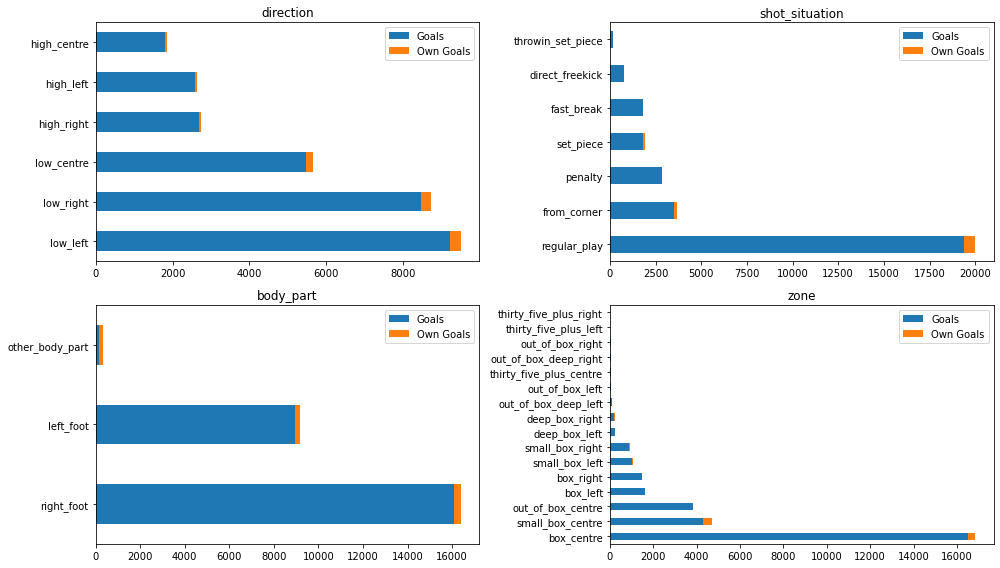

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(14,8),tight_layout=True)
plot_category('direction', axes[0,0])
plot_category('shot_situation', axes[0,1])
plot_category('body_part', axes[1,0])
plot_category('zone', axes[1,1])

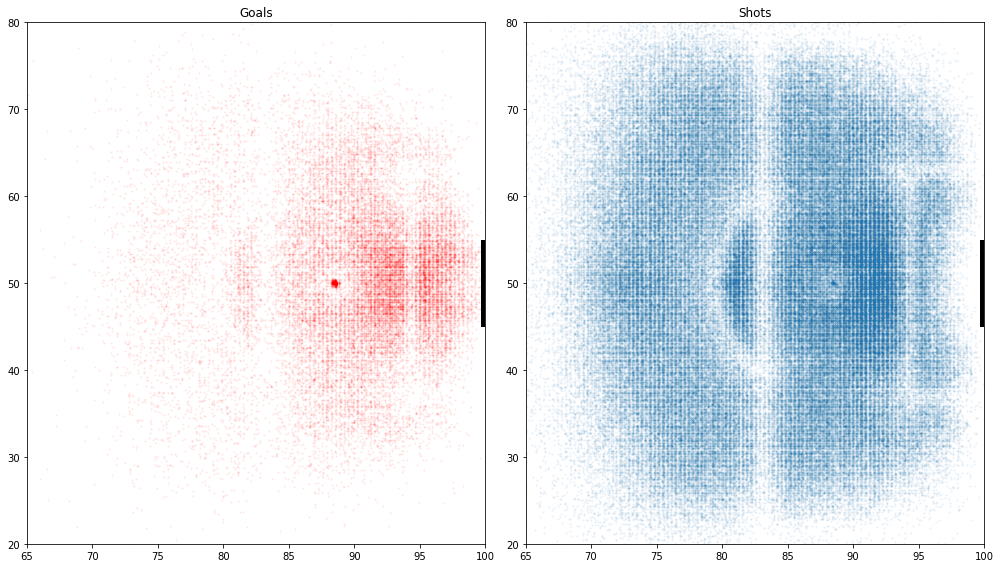

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(14,8),tight_layout=True)
plot_coords('select x, y as y from core.events join core.event_types on event_types.id = events.type where is_goal and not is_own_goal and event_types.name = \'goal\'', 'Goals', alpha=0.05,ax=axes[0],s=2,c='red')
plot_coords('select x, y as y from core.events join core.event_types on event_types.id = events.type where not is_goal and is_shot','Shots',alpha=0.05,ax=axes[1],s=2)

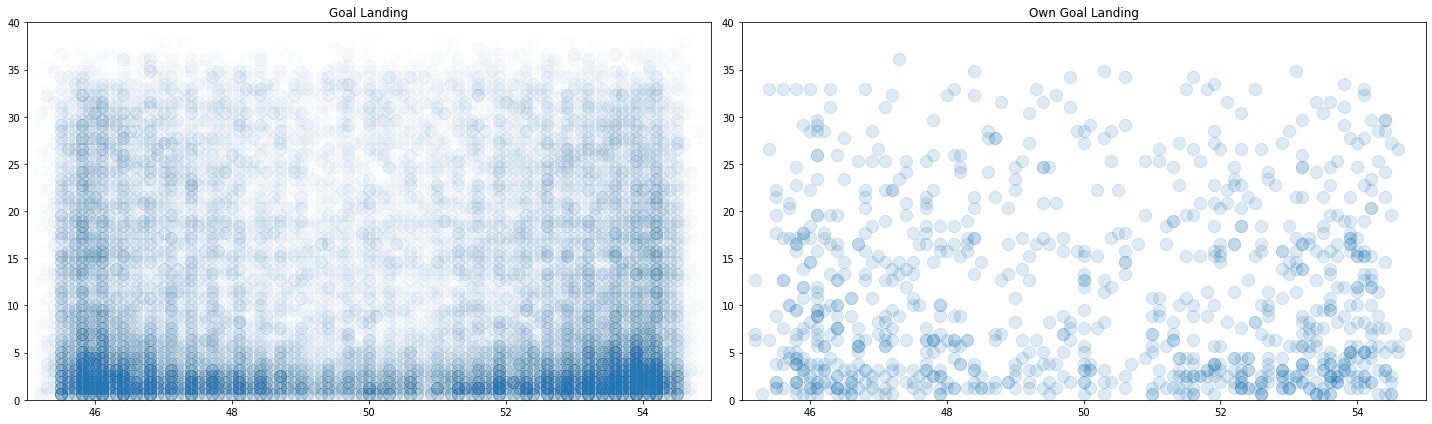

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(14,8),tight_layout=True)
plot_goalline_coords('select goal_mouth_y, goal_mouth_z from core.events join core.event_types on event_types.id = events.type where event_types.name = \'goal\' and not is_own_goal', 'Goal Landing',aplha=0.01,ax=axes[0])
plot_goalline_coords('select goal_mouth_y, goal_mouth_z from core.events join core.event_types on event_types.id = events.type where event_types.name = \'goal\' and is_own_goal', 'Own Goal Landing',aplha=0.15,ax=axes[1])